In [1]:
import pandas as pd
import numpy as np 
import nltk
from collections import Counter
from nltk.corpus import stopwords
from sklearn.metrics import log_loss
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from scipy.optimize import minimize
import xgboost as xgb
from sklearn.cross_validation import train_test_split
import multiprocessing
import difflib

/home/takaya/.pyenv/versions/anaconda3-4.3.0/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
features = [
    #'question1_nouns',
    #'question2_nouns',
    #'q1_tok_words',
    #'q2_tok_words',
    'z_noun_match',
    'z_len1',
    'z_len2',
    'z_word_len1',
    'z_word_len2',
    'z_match_ratio',
    'z_word_match',
    'z_word_match_idf',
    'z_tfidf_sum1',
    'z_tfidf_sum2',
    'z_tfidf_mean1',
    'z_tfidf_mean2',
    'z_tfidf_len1',
    'z_tfidf_len2',
    'z_n_sim',
    
    'common_words_lemm',
    'n_sim_lemm',
    'n_sim_lemm_stop',
    's2v_sum_dist',
    's2v_ave_dist',
    
    'sum_prob_weight_common_words',
    'top_similarity',
    'min_sim',
    'max_sim',
]

In [3]:
features_6w1h = [
#     'q1_what',
#     'q2_what',
#     'q1_when',
#     'q2_when',
#     'q1_why',
#     'q2_why',
#     'q1_where',
#     'q2_where',
#     'q1_who',
#     'q2_who',
#     'q1_which',
#     'q2_which',
#     'q1_how',
#     'q2_how',
    'what',
    'when',
    'why',
    'where',
    'who',
    'which',
    'how'
]

features.extend(features_6w1h)

In [4]:
features_clean = [
    'clean_lemm_stem_len1',
    'clean_lemm_stem_len2',
    'clean_lemm_stem_word_len1',
    'clean_lemm_stem_word_len2',
    'clean_lemm_stem_match_ratio',
    'clean_lemm_stem_word_match',
    'clean_lemm_stem_word_match_idf',
    'clean_lemm_stem_tfidf_sum1',
    'clean_lemm_stem_tfidf_sum2',
    'clean_lemm_stem_tfidf_mean1',
    'clean_lemm_stem_tfidf_mean2',
#     'clean_lemm_stem_tfidf_len1',
#     'clean_lemm_stem_tfidf_len2'
]

features.extend(features_clean)

In [5]:
def read_data(t, features):
#     data = pd.read_csv('../input/{}.csv'.format(t))
    data = pd.read_csv('/home/takaya/Downloads/data/quora_features.csv')#[:100]
    for feature in features:
        data = pd.merge(data, pd.read_pickle('../feature/{}_{}.pkl'.format(t, feature)))
    data.fillna(0.0)
    return data

def read_feature(t, features):
    key = 'id' if t == 'train' else 'test'
    data = pd.DataFrame(columns=[key])
    for feature in features:
        data = pd.merge(data, pd.read_pickle('../feature/{}_{}.pkl'.format(t, feature)), how='outer')
    return data

In [6]:
train = read_data('train', features)#[:100]

In [7]:
__w = [
#     'skew_q1vec',
    'canberra_distance',
    'cosine_distance',
    'minkowski_distance',
    'cityblock_distance',
    'jaccard_distance',
    'euclidean_distance',
#     'kur_q2vec',
#     'len_word_q2',
#     'len_char_q1',
#     'len_q2',
#     'norm_wmd',
    'fuzz_qratio',
    'fuzz_token_set_ratio',
#     'len_q1',
    'fuzz_token_sort_ratio',
    'fuzz_WRatio',
    'braycurtis_distance',
    'fuzz_partial_token_set_ratio',
#     'len_char_q2',
#     'skew_q2vec',
    'fuzz_partial_token_sort_ratio',
#     'kur_q1vec',
#     'len_word_q1',
#     'wmd',
    'fuzz_partial_ratio',
#     'common_words',
    'diff_len'
]
features.extend(__w)

In [8]:
def balance_data_size(x, y):
    x_pos = x[y == 1]
    x_neg = x[y == 0]
    y_pos = y[y == 1]
    y_neg = y[y == 0]
    
#     p = 0.17426778573248283
    p = 0.165
    while len(x_pos) / (len(x_pos) + len(x_neg)) > p:
        x_neg = pd.concat([x_neg, x_neg])
        y_neg = pd.concat([y_neg, y_neg])
    need_negs = int((1 - p) / p * len(x_pos))
    x_neg = x_neg[:need_negs]
    y_neg = y_neg[:need_negs]
  
    x = pd.concat([x_pos, x_neg])
    y = pd.concat([y_pos, y_neg])
    return (x, y)

In [9]:
def split_train_valid_correctly(train):
    new_train_ratio = 0.8

    def normalize_question(s):
        return str(s).lower().strip()

    from collections import defaultdict
    inverted_index = defaultdict(list)
    for index, row in train.iterrows():
        inverted_index[normalize_question(row['question1'])].append(index)
        inverted_index[normalize_question(row['question2'])].append(index)
    len(inverted_index)
    
    import random
    rows = list(train.iterrows())
    random.seed(810)
    random.shuffle(rows)
    new_train_indexes = set()
    for index, row in rows:
        if len(new_train_indexes) >= len(train) * new_train_ratio:
            break

        new_train_indexes.update(inverted_index[normalize_question(row['question1'])])
        new_train_indexes.update(inverted_index[normalize_question(row['question2'])])

    new_valid_indexes = [index for index, row in train.iterrows() if index not in new_train_indexes]

    new_train = train.iloc[list(new_train_indexes)]
    new_valid = train.iloc[list(new_valid_indexes)]

    print('size ratio')
    print(len(new_train_indexes) / len(train))
    print(len(new_valid_indexes) / len(train))

    print('duplicate ratio')
    print(sum(train.is_duplicate) / len(train))
    print(sum(new_train.is_duplicate) / len(new_train))
    print(sum(new_valid.is_duplicate) / len(new_valid))
    
    return (new_train, new_valid)

split_train, split_valid = split_train_valid_correctly(train)

x_train, y_train = balance_data_size(split_train[features], split_train['is_duplicate'])
x_valid, y_valid = balance_data_size(split_valid[features], split_valid['is_duplicate'])

print('balance')
print(sum(y_train) / len(y_train))
print(sum(y_valid) / len(y_valid))

size ratio
0.8
0.2
duplicate ratio
0.369197853026
0.40434156175
0.228623018131
balance
0.165000182945
0.165000535542


In [10]:
params = {}
params["objective"] = "binary:logistic"
params['eval_metric'] = 'logloss'
params["eta"] = 0.03
params["subsample"] = 0.7
params["min_child_weight"] = 1
params["colsample_bytree"] = 0.7
params["max_depth"] = 10
params["silent"] = 1
params["seed"] = 87978979

d_train = xgb.DMatrix(x_train, label=y_train)
d_valid = xgb.DMatrix(x_valid, label=y_valid)
watchlist = [(d_train, 'train'), (d_valid, 'valid')]
bst = xgb.train(params, d_train, 10000, watchlist, early_stopping_rounds=50, verbose_eval=100) #change to higher #s

[0]	train-logloss:0.675757	valid-logloss:0.674757
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 50 rounds.
[100]	train-logloss:0.286838	valid-logloss:0.279897
[200]	train-logloss:0.253224	valid-logloss:0.261404
[300]	train-logloss:0.236292	valid-logloss:0.257934
[400]	train-logloss:0.221668	valid-logloss:0.255874
[500]	train-logloss:0.208907	valid-logloss:0.254549
[600]	train-logloss:0.197266	valid-logloss:0.253364
[700]	train-logloss:0.187966	valid-logloss:0.252613
[800]	train-logloss:0.179369	valid-logloss:0.252316
[900]	train-logloss:0.170681	valid-logloss:0.251906
[1000]	train-logloss:0.163254	valid-logloss:0.251474
[1100]	train-logloss:0.156977	valid-logloss:0.251324
Stopping. Best iteration:
[1068]	train-logloss:0.159044	valid-logloss:0.25126



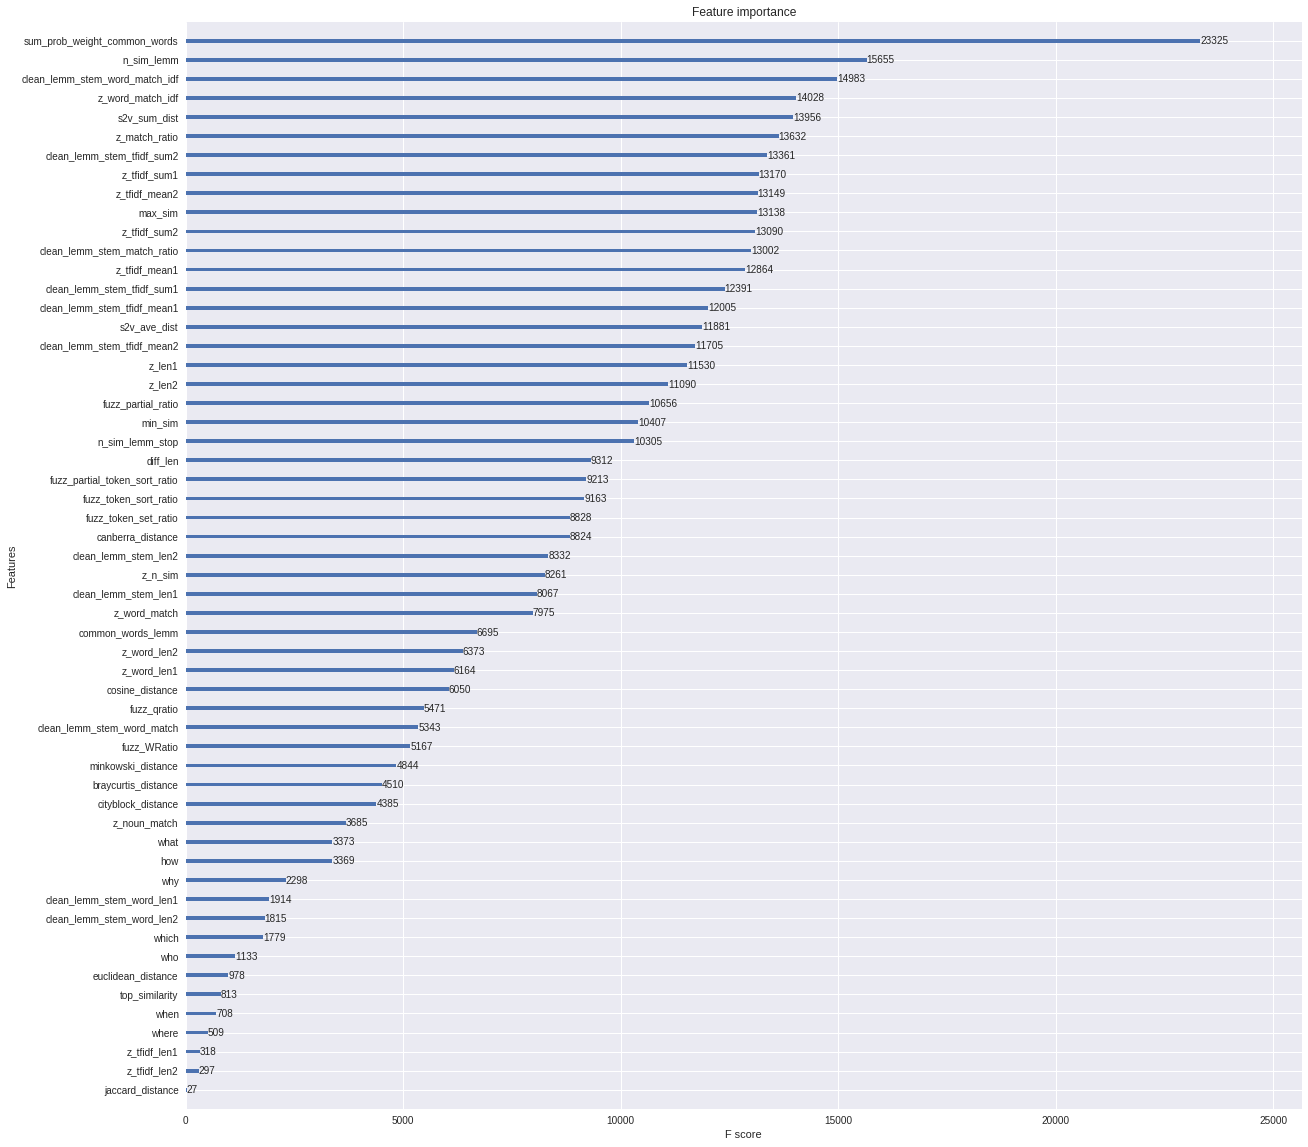

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

plt.rcParams['figure.figsize'] = (20.0, 20.0)
xgb.plot_importance(bst); plt.show()

In [12]:
# test = read_data('test', features)#[:100]
# sub = pd.DataFrame()
# sub['test_id'] = test['test_id']
# sub['is_duplicate'] = bst.predict(xgb.DMatrix(test[features]))

# sub.to_csv('result.csv', index=False)

In [13]:
ori_train_pred = bst.predict(xgb.DMatrix(train[features]))
ori_train_bin_pred = np.where(ori_train_pred < 0.5, 0, 1)
print('accuracy: {}'.format(sum(train.is_duplicate == ori_train_bin_pred) / len(train)))

accuracy: 0.8808973756461945


In [14]:
train_pred = bst.predict(xgb.DMatrix(split_train[features]))
train_bin_pred = np.where(train_pred < 0.5, 0, 1)
print('accuracy: {}'.format(sum(split_train.is_duplicate == train_bin_pred) / len(split_train)))

accuracy: 0.8886411981498429


In [15]:
valid_pred = bst.predict(xgb.DMatrix(split_valid[features]))
valid_bin_pred = np.where(valid_pred < 0.5, 0, 1)
print('accuracy: {}'.format(sum(split_valid.is_duplicate == valid_bin_pred) / len(split_valid)))

accuracy: 0.8499220856316011


In [16]:
train['pred'] = ori_train_pred

def calc_score(row):
    return log_loss([row['is_duplicate']], [row['pred']], labels=[0, 1])

train['loss'] = train.apply(calc_score, axis=1)

In [17]:
text_features = [
    'q1_tokenized',
    'q2_tokenized',
    'question1_nouns',
    'question2_nouns',
    'q1_lemmatized',
    'q2_lemmatized',
    'q1_pos_tagged',
    'q2_pos_tagged',
    'clean_q1_lemmatized_stem',
    'clean_q2_lemmatized_stem'
]

text_features_train = read_feature('train', text_features)

In [18]:
data = pd.merge(train, text_features_train, how='outer')

In [19]:
pd.set_option("display.max_colwidth", -1)
pd.set_option("display.max_rows", 101)

In [20]:
data.sort_values(by='loss', ascending=False)[:1000].to_html('gao.html')

In [21]:
a = data.iloc[361387]

In [22]:
a

id                                361387                                                                                             
question1                         What ethnicity were the Moors of Sicily?                                                           
question2                         Who were the moors?                                                                                
is_duplicate                      1                                                                                                  
len_q1                            40                                                                                                 
len_q2                            19                                                                                                 
diff_len                          21                                                                                                 
len_char_q1                       18                          